In [66]:
import pandas as pd
import os
import pickle
import numpy as np
from IPython.display import Image,display,HTML

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [67]:
path=r'D:\python data\movie_recommendation_project'

In [68]:
all_data=[]
for file in os.listdir(path):
    if 'all_data_' in file:
        data=pickle.load(open(os.path.join(path,file),'rb'))
        all_data=all_data+data
        
print(len(all_data))

126691


In [69]:
df=pd.DataFrame(all_data)

In [70]:
release_year=df['Year'].apply(lambda x:x.split('|')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
release_year=release_year.apply(lambda x:str(x).split('.')[0] if x!='nan' else None)

length=df['Year'].apply(lambda x:x.split('|')[-1] if isinstance(x,str) else None)
length=length.apply(lambda x:
             int(x.split('h')[0])*60+int(x.split('h')[-1].split('m')[0]) if isinstance(x,str) and 'h' in x and 'm' in x else
             int(x.split('h')[0])*60 if isinstance(x,str) and 'h' in x and 'm' not in x else
             int(x.split('m')[0]) if isinstance(x,str) and 'h' not in x and 'm' in x else None

             )

df.insert(df.columns.get_loc('Year')+1,'Release Year',release_year)
df.insert(df.columns.get_loc('Year')+2,'Length in Min',length)
df=df.drop(columns='Year')

In [71]:
imdb_rating=df['Rating'].apply(lambda x:float(x.split('|')[0]) if isinstance(x,str) else None)

rating_count=df['Rating'].apply(lambda x:
                   float(x.split('|')[-1].replace('K',''))*10**3 if isinstance(x,str) and 'K' in x else
                   float(x.split('|')[-1].replace('M',''))*10**6 if isinstance(x,str) and 'M' in x else
                   float(x.split('|')[-1]) if isinstance(x,str) else None
                   )

df.insert(df.columns.get_loc('Rating')+1,'IMDB Rating',imdb_rating)
df.insert(df.columns.get_loc('Rating')+2,'Rating Count',rating_count)
df=df.drop(columns='Rating')

In [72]:
df=df.drop(columns='Summary')

In [73]:
df['Director'][0]

'Director|Urban Gad|Writers|Urban Gad|Gebhard Schätzler-Perasini|Stars|Asta Nielsen|Valdemar Psilander|Gunnar Helsengreen'

In [74]:
import re

def get_director(text):
    try:
        return re.search(r'(?:Director|Directors)\|(.*?)(?:\|Writer|Writers|Star|Stars)\|', text).group(1)
    except:
        None


def get_writer(text):
    try:
        return re.search(r'(?:Writer|Writers)\|(.*?)(?:\|Star|Stars)\|', text).group(1)
    except:
        None

def get_star(text):
    try:
        return re.search(r'(?:Star|Stars)\|(.*)', text).group(1)
    except:
        None



directors=df['Director'].apply(lambda x:get_director(x) if isinstance(x,str) else None)
writers=df['Director'].apply(lambda x:get_writer(x) if isinstance(x,str) else None)
stars=df['Director'].apply(lambda x:get_star(x) if isinstance(x,str) else None)


df.insert(df.columns.get_loc('Director')+1,'Directors',directors)
df.insert(df.columns.get_loc('Director')+2,'Writers',writers)
df.insert(df.columns.get_loc('Director')+3,'Stars',stars)
df=df.drop(columns='Director')


In [75]:
df.isna().mean()*100

Movie URL        0.000000
Title            0.051306
Poster           0.242322
Release Year     0.000000
Length in Min    1.545493
IMDB Rating      0.052885
Rating Count     0.052885
Plot             0.051306
Directors        0.670134
Writers          5.570246
Stars            1.067163
Genres           0.138921
dtype: float64

In [37]:
df=df[df['Rating Count']>=1000]
len(df)

42430

In [12]:
df.to_csv('movies.csv',index=False)

# Visualization

In [76]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

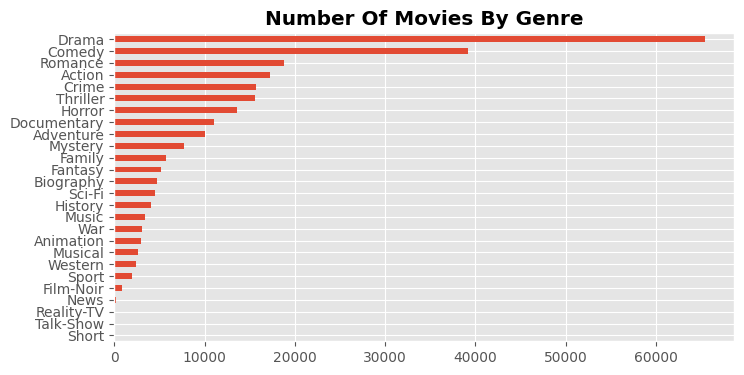

In [77]:
g = pd.Series([genre for genres in df.dropna(subset=['Genres'])['Genres'].str.split('|') for genre in genres]).value_counts().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(8,4))
g.plot.barh(ax=ax)
ax.set_title('Number Of Movies By Genre', fontweight='bold')

#plt.savefig('number_of_movies_by_genre.png')

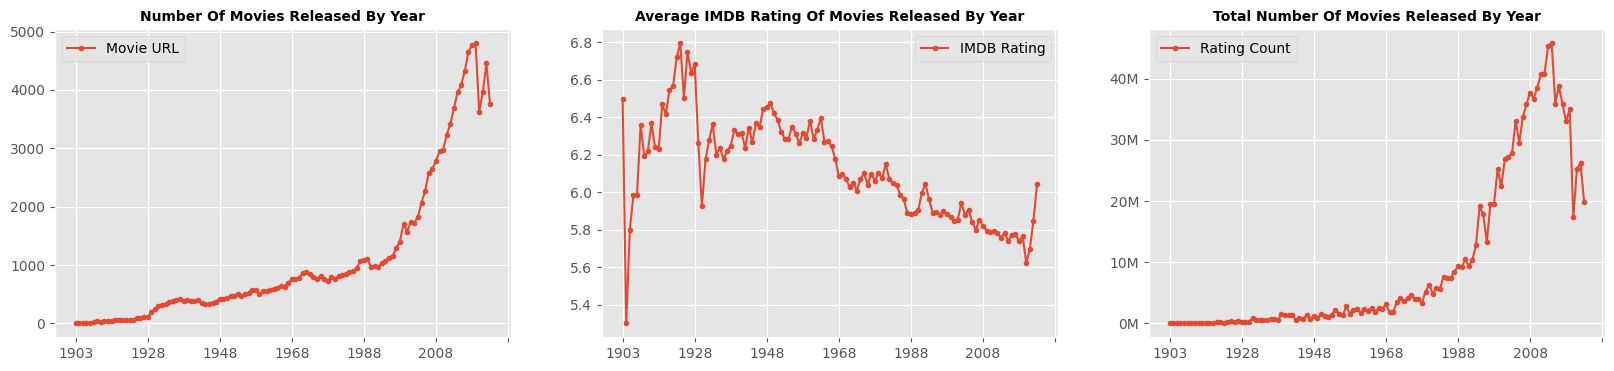

In [78]:
import matplotlib.ticker as ticker

g=df.groupby('Release Year').agg({'IMDB Rating':'mean','Rating Count':'sum','Movie URL':'count'})[:-1]

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,4))

g.plot(ax=ax1,marker='.',y='Movie URL')
ax1.set_title('Number Of Movies Released By Year',fontweight='bold',size=10)
ax1.set_xlabel(None)

g.plot(ax=ax2,marker='.',y='IMDB Rating')
ax2.set_title('Average IMDB Rating Of Movies Released By Year',fontweight='bold',size=10)
ax2.set_xlabel(None)

g.plot(ax=ax3,marker='.',y='Rating Count')
ax3.set_title('Total Number Of Movies Released By Year',fontweight='bold',size=10)
ax3.set_xlabel(None)

formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}M'.format(x / 1000000))
ax3.yaxis.set_major_formatter(formatter)


#plt.savefig('timeseries.png')

In [79]:
df['Directors']=df['Directors'].apply(lambda x: sorted([i.strip() for i in x.split('|') if i.strip()]) if isinstance(x, str) else None)
df['Directors']=df['Directors'].apply(lambda x:', '.join(x) if isinstance(x,list) else None)

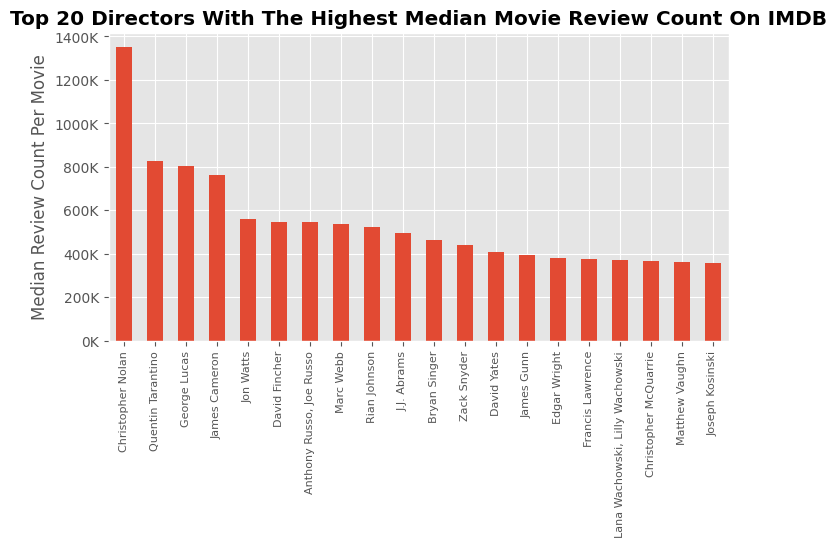

In [84]:
g=df.groupby('Directors').filter(lambda x:x['Movie URL'].count()>=5)\
    .groupby('Directors')['Rating Count'].median().sort_values(ascending=False).head(20)

fig,ax=plt.subplots(figsize=(8,4))
g.plot.bar(ax=ax)
ax.set_title('Top 20 Directors With The Highest Median Movie Review Count On IMDB',fontweight='bold')
ax.set_ylabel('Median Review Count Per Movie')

formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}K'.format(x / 1000))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel(None)
ax.set_xticks(range(len(g.index)),g.index,size=8,rotation=90)
#for i in range(len(g)):
    #ax.text(i,0,g.index[i],ha='center',va='bottom',fontweight='bold',size=8,rotation=90)

#plt.savefig('top_directors.png')